In [ ]:
import os
import time
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from IPython.display import clear_output
from tensorflow.keras.models import Sequential

c:\Users\Cr0l3y\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
(train_images, train_labels), _ = tf.keras.datasets.fashion_mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32")
train_images = (train_images - 127.5)/127.5

In [4]:
batch_size = 256
train_ds = tf.data.Dataset.from_tensor_slices(train_images).shuffle(6000).batch(batch_size)

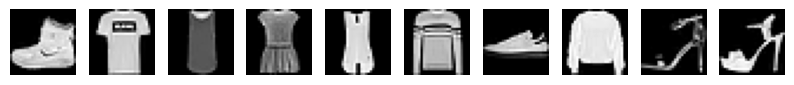

In [5]:
image_show = 10
plt.figure(figsize=(10,10))
for i in range(image_show):
    plt.subplot(1, image_show, i+1)
    plt.imshow(train_images[i].reshape(28,28), cmap="gray")
    plt.axis("off")

In [ ]:
def constroi_gerador():
    modelo = Sequential()
    modelo.add(layers.Input(shape=(100,)))
    modelo.add(layers.Dense(7*7*256, use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())
    modelo.add(layers.Reshape((7, 7, 256)))
    modelo.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())
    modelo.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    modelo.add(layers.BatchNormalization())
    modelo.add(layers.LeakyReLU())
    modelo.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))

    return modelo

In [11]:
gerador = constroi_gerador()

(-0.5, 27.5, 27.5, -0.5)

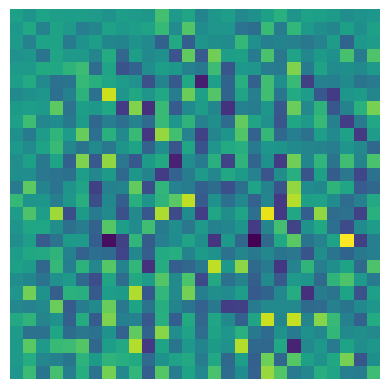

In [15]:
dimensao_ruido = 100
ruido = tf.random.normal([1, dimensao_ruido])
imagem_gerada = gerador(ruido, training=False)
plt.imshow(imagem_gerada[0]*127.5+127.5)
plt.axis("off")

In [ ]:
def constroi_discriminador():
    modelo = Sequential()
    modelo.add(layers.Input(shape=(28, 28, 1)))
    modelo.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same'))
    modelo.add(layers.LeakyReLU())
    modelo.add(layers.Dropout(0.3))
    modelo.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    modelo.add(layers.LeakyReLU())
    modelo.add(layers.Dropout(0.3))
    modelo.add(layers.Flatten())
    modelo.add(layers.Dense(1))

    return modelo

In [19]:
discriminador = constroi_discriminador()
decisao = discriminador(imagem_gerada)
print(decisao)

tf.Tensor([[0.00286235]], shape=(1, 1), dtype=float32)


Função de custo

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def custo_descriminador(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss+ fake_loss
    return total_loss
def custo_gerador(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
otimizador_gerador = tf.keras.optimizers.Adam(1e-4)
otimizador_discriminador = tf.keras.optimizers.Adam(1e-4)

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer = otimizador_gerador,
                                 discriminator_optimizer = otimizador_discriminador,
                                 generator = gerador,
                                 discriminator = discriminador)

In [30]:
epocas = 50
dimensao_ruido = 100
numero_ex_treinamentos =16
seed = tf.random.normal([numero_ex_treinamentos, dimensao_ruido])

In [ ]:
@tf.function
def passo_treino(images):
    ruido = tf.random.normal([batch_size, dimensao_ruido])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = gerador(ruido, training=True)
        real_output = discriminador(images, training=True)
        fake_output = discriminador(generated_images, training=True)
        gen_loss = custo_gerador(fake_output)
        disc_loss = custo_descriminador(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, gerador.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminador.trainable_variables)
    otimizador_gerador.apply_gradients(zip(gradients_of_generator, gerador.trainable_variables))
    otimizador_discriminador.apply_gradients(zip(gradients_of_discriminator, discriminador.trainable_variables))

In [ ]:
def treino(dataset, epocas):
    for epoca in range(epocas):
        start = time.time()
        for image_batch in dataset:
           passo_treino(image_batch)
        clear_output(wait=True)
        gera_e_salva_imagens(gerador,
                                 epoca + 1,
                                 seed)
        if (epoca + 1) % 15 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
        print('Tempo por época {} é {} s'.format(epoca + 1, time.time()-start))
    clear_output(wait=True)
    gera_e_salva_imagens(gerador,
                                 epoca + 1,
                                 seed)
def gera_e_salva_imagens(modelo, epoca, entrada):
  previsao = modelo(entrada, training=False)
  fig = plt.figure(figsize=(4, 4))
  for i in range(previsao.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(previsao[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoca))
  plt.show()

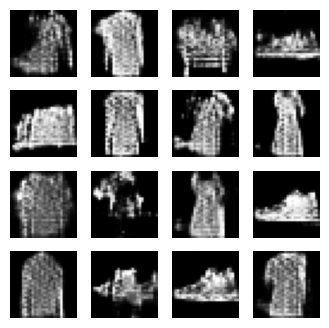

In [35]:
treino(train_ds, epocas)

In [36]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [37]:
gerador.save("modelo_gerador.keras")

In [38]:
from tensorflow.keras.models import load_model
gerador_carregado = load_model('modelo_gerador.keras')

In [ ]:
new_noise = tf.random.normal([1, dimensao_ruido])
new_generated_image = gerador_carregado(new_noise, training=False)

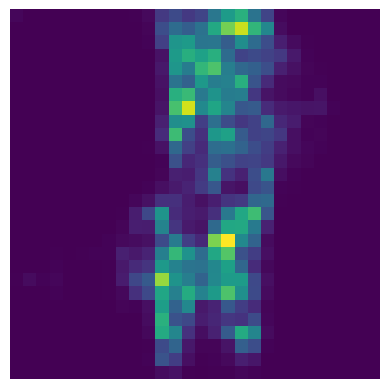

In [ ]:
plt.imshow((new_generated_image[0] * 127.5 + 127.5).numpy())
plt.axis('off')
plt.show()